# Linear Regression

In [79]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import uniform
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.pipeline import Pipeline
%matplotlib inline 


### Data Preprocessing

In [48]:
df = pd.read_csv('../flight-delay-dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [49]:
# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

In [50]:
# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

In [51]:
# Remove TAIL_NUM and TAXI_OUT
df.drop(columns=['TAIL_NUM', 'TAXI_OUT', 'DEP_TIME_M'], inplace=True)

In [52]:
# Convert DEW_POINT to int
df['Dew Point'] = df['Dew Point'].astype(int)

In [53]:
# Encode categorical variables
columns_to_encode = ['OP_UNIQUE_CARRIER', 'DEST', 'Wind', 'Condition']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

In [54]:
# Remove all values beyond 3 standard deviations from the mean
mean_dep_delay = df_encoded['DEP_DELAY'].mean()
std_dep_delay = df_encoded['DEP_DELAY'].std()
upper_threshold = mean_dep_delay + (3 * std_dep_delay)
df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]


# Remove all values below 0
df_encoded = df_encoded[df_encoded['DEP_DELAY'] >= 15]

### Data Normalization (Log/Sqrt methods were not used in final result due to poor outcome)

In [55]:
# # Test log method

# # Log-transform the target variable
# df_encoded['DEP_DELAY'] = np.log1p(df_encoded['DEP_DELAY'])

# # Separate features (X) and target (y)
# X = df_encoded.drop(columns=['DEP_DELAY'])
# y = df_encoded['DEP_DELAY']

# # Apply MinMax scaling to all features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Convert back to DataFrame (optional)
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Train Linear Regression Model
# lm = LinearRegression()
# lm.fit(X_train, y_train)

# # Predict on the test set (log scale)
# y_pred_log = lm.predict(X_test)

# # Reverse log transformation (convert back to original scale)
# y_pred = np.expm1(y_pred_log)
# y_test_original = np.expm1(y_test)

# # Calculate MSE
# mse = mean_squared_error(y_test_original, y_pred)
# print("MSE:", mse)

# # Calculate MAE
# mae = mean_absolute_error(y_test_original, y_pred)
# print("MAE:", mae)


# # Produces: Worse value
# # MSE: 731.9555235013917
# # MAE: 20.56363831986314

In [56]:
# # Test Squareroot method

# # Square root transform the target variable
# df_encoded['DEP_DELAY'] = np.sqrt(df_encoded['DEP_DELAY'])

# # Separate features (X) and target (y)
# X = df_encoded.drop(columns=['DEP_DELAY'])
# y = df_encoded['DEP_DELAY']

# # Apply MinMax scaling to all features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # Convert back to DataFrame (optional)
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Train Linear Regression Model
# lm = LinearRegression()
# lm.fit(X_train, y_train)

# # Predict on the test set (square root scale)
# y_pred_sqrt = lm.predict(X_test)

# # Reverse square root transformation (convert back to original scale)
# y_pred = np.square(y_pred_sqrt)
# y_test_original = np.square(y_test)

# # Calculate MSE
# mse = mean_squared_error(y_test_original, y_pred)
# print("MSE:", mse)

# # Calculate MAE
# mae = mean_absolute_error(y_test_original, y_pred)
# print("MAE:", mae)

# # Produces: Very similar value
# # MSE: 712.697631746199
# # MAE: 21.075307053035456

### Train/Test Split

In [57]:
# Split 80/20 train-test

X = df_encoded.drop(columns=['DEP_DELAY'])
y = df_encoded['DEP_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### Develop and Fit Model

In [58]:
# Find MSE if you were to predict all with the average
y_mean = y_train.mean()
y_train_pred_mean = np.full(y_train.shape, y_mean)
y_test_pred_mean = np.full(y_test.shape, y_mean)
mse_train_mean = mean_squared_error(y_train, y_train_pred_mean)
mse_test_mean = mean_squared_error(y_test, y_test_pred_mean)
mae_train_mean = mean_absolute_error(y_train, y_train_pred_mean)
mae_test_mean = mean_absolute_error(y_test, y_test_pred_mean)
print(f'Mean MSE Test: {mse_test_mean}')
print(f'Mean MAE Test: {mae_test_mean}')

Mean MSE Test: 726.0180249932113
Mean MAE Test: 22.20996029186083


In [59]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict on the test set
y_pred = lm.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MSE: 714.5088685673621
MAE: 21.892322984188578


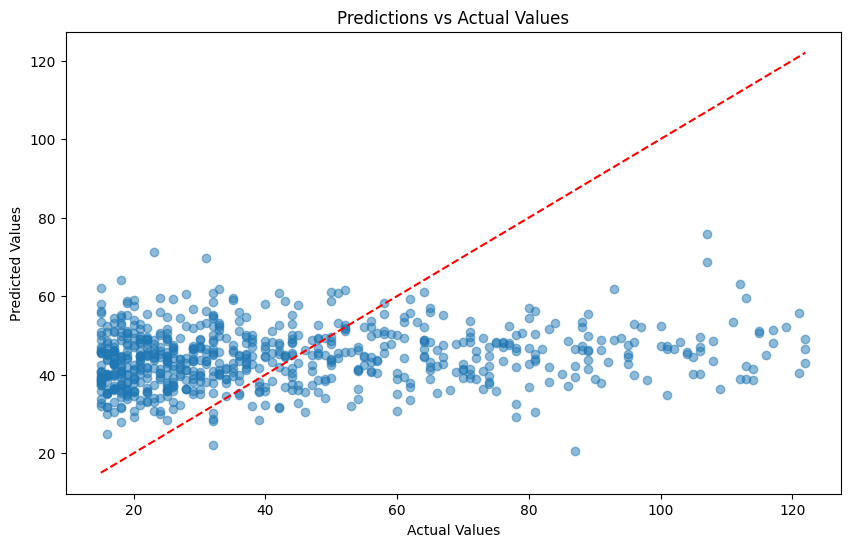

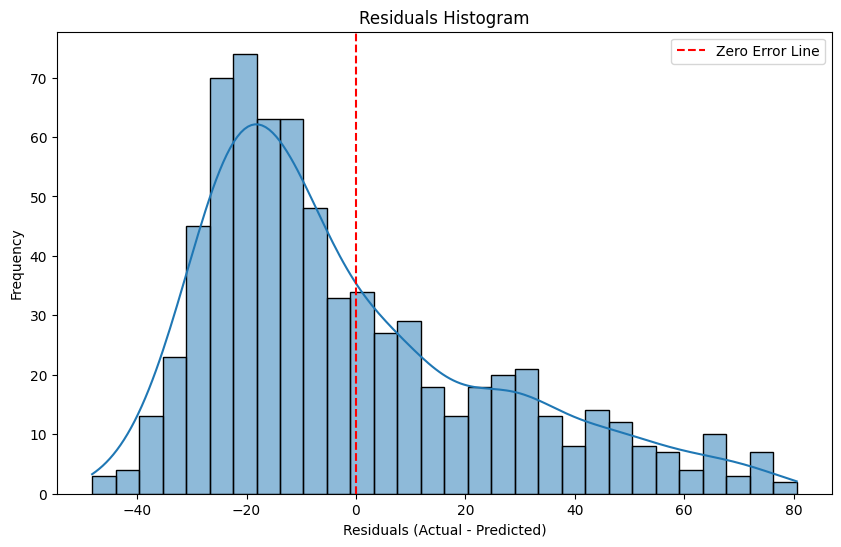

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()

### Feature Importance Selection

##### Tried individual importance selection through abs value but did not use for final result due to poor outcome

In [61]:

# Get Feature Importance from Linear Regression
feature_importance_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lm.coef_  # Coefficients as importance
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importance from Linear Regression (Top to Bottom):")
print(feature_importance_lr)


Feature Importance from Linear Regression (Top to Bottom):
                          Feature  Importance
20           OP_UNIQUE_CARRIER_HA   16.558051
68                       DEST_PSE   14.719085
108      Condition_Cloudy / Windy   14.221701
32                       DEST_BUR   12.019756
122  Condition_Light Snow / Windy   11.658545
..                            ...         ...
112                 Condition_Fog  -12.166398
113         Condition_Fog / Windy  -12.678431
128        Condition_Rain / Windy  -14.757301
85                       DEST_SRQ  -17.545556
58                       DEST_OAK  -19.433224

[132 rows x 2 columns]


In [62]:
# Get the absolute values of the coefficients
feature_importance_lr['Absolute_Importance'] = abs(feature_importance_lr['Importance'])

# Sort the features by absolute importance
feature_importance_lr_sorted = feature_importance_lr.sort_values(by='Absolute_Importance', ascending=False)

# Display sorted feature importance
print("Sorted Feature Importance (by absolute values):")
print(feature_importance_lr_sorted)

Sorted Feature Importance (by absolute values):
                           Feature    Importance  Absolute_Importance
58                        DEST_OAK -1.943322e+01         1.943322e+01
85                        DEST_SRQ -1.754556e+01         1.754556e+01
20            OP_UNIQUE_CARRIER_HA  1.655805e+01         1.655805e+01
128         Condition_Rain / Windy -1.475730e+01         1.475730e+01
68                        DEST_PSE  1.471908e+01         1.471908e+01
..                             ...           ...                  ...
109      Condition_Drizzle and Fog -1.776357e-15         1.776357e-15
115   Condition_Heavy Rain / Windy -1.665335e-15         1.665335e-15
131   Condition_Wintry Mix / Windy  0.000000e+00         0.000000e+00
129                 Condition_Snow  0.000000e+00         0.000000e+00
118  Condition_Light Freezing Rain  0.000000e+00         0.000000e+00

[132 rows x 3 columns]


In [78]:
# Define thresholds
thresholds = [1, 3, 10]

# Loop through thresholds and print the selected features
for threshold in thresholds:
    selected_features = feature_importance_lr_sorted[feature_importance_lr_sorted['Absolute_Importance'] >= threshold]
    
    # Print total number of columns after applying threshold
    print(f"Threshold: {threshold}")
    print(f"Total columns selected: {len(selected_features)}")
    print(f"Selected features: {selected_features['Feature'].tolist()}")
    print("-" * 50)
    
    # Filter dataset with selected features
    X_train_selected = X_train[selected_features['Feature']]
    X_test_selected = X_test[selected_features['Feature']]

Threshold: 1
Total columns selected: 94
Selected features: ['DEST_OAK', 'DEST_SRQ', 'OP_UNIQUE_CARRIER_HA', 'Condition_Rain / Windy', 'DEST_PSE', 'Condition_Cloudy / Windy', 'Condition_Fog / Windy', 'Condition_Fog', 'DEST_BUR', 'Condition_Light Snow / Windy', 'DEST_ORH', 'DEST_BQN', 'Condition_Heavy Rain', 'DEST_ABQ', 'DEST_SAT', 'DEST_EGE', 'DEST_CHS', 'DEST_RNO', 'Condition_Light Drizzle / Windy', 'DEST_ONT', 'DEST_SAV', 'DEST_CVG', 'Condition_Fair / Windy', 'Condition_Light Rain / Windy', 'DEST_PHL', 'DEST_SJU', 'DEST_RIC', 'DEST_BWI', 'Condition_Light Snow', 'DEST_SJC', 'DEST_SLC', 'DEST_ORD', 'DEST_JAC', 'DEST_PSP', 'OP_UNIQUE_CARRIER_DL', 'DEST_RSW', 'DEST_DTW', 'Pressure', 'OP_UNIQUE_CARRIER_OO', 'Condition_Rain', 'DEST_FLL', 'DEST_IAH', 'Condition_Partly Cloudy / Windy', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_9E', 'Wind_W', 'Wind_ENE', 'DEST_BNA', 'Wind_NE', 'DEST_PWM', 'DEST_MCO', 'DEST_JAX', 'Condition_Light Drizzle', 'Condition_Wintry Mix', 'DEST_CLE', 'Wind_N', 'DEST_OR

In [ ]:
selected_features = feature_importance_lr_sorted[feature_importance_lr_sorted['Absolute_Importance'] >= 0.5]['Feature'].tolist()

# Filter the training and testing sets to include only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain Linear Regression on selected features
lr_selected = LinearRegression()
lr_selected.fit(X_train_selected, y_train)

# Evaluate new model
y_pred_selected = lr_selected.predict(X_test_selected)

# Calculate MSE (Mean Squared Error)
mse_selected = mean_squared_error(y_test, y_pred_selected)

print("MSE (Selected Features):", mse_selected)

MSE (Selected Features): 733.8531718576288


### Feature Standardization (Did not use in final result due to poor outcome)

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on training features and transform both training and testing features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print mean and std after scaling
print("After scaling - X_train mean:\n", X_train_scaled.mean(axis=0))
print("After scaling - X_train std:\n", X_train_scaled.std(axis=0))

# Initialize Linear Regression model
lm = LinearRegression()

# Fit the model on the scaled data
lm.fit(X_train_scaled, y_train)

# Make predictions on the test set (scaled)
y_pred = lm.predict(X_test_scaled)

# Calculate MSE (Mean Squared Error) on the original scale
mse = mean_squared_error(y_test, y_pred)
print("MSE (Original scale):", mse)

# Calculate MAE (Mean Absolute Error) on the original scale
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Original scale):", mae)

Before scaling - X_train mean:
 MONTH                              8.633853
DAY_OF_MONTH                      15.240793
DAY_OF_WEEK                        4.072946
CRS_ELAPSED_TIME                 220.190156
DISTANCE                        1232.118980
                                   ...     
Condition_Rain                     0.026558
Condition_Rain / Windy             0.001062
Condition_Snow                     0.000000
Condition_Wintry Mix               0.006020
Condition_Wintry Mix / Windy       0.000000
Length: 132, dtype: float64
Before scaling - X_train std:
 MONTH                             4.809050
DAY_OF_MONTH                      8.510964
DAY_OF_WEEK                       2.053739
CRS_ELAPSED_TIME                117.467911
DISTANCE                        867.244364
                                   ...    
Condition_Rain                    0.160816
Condition_Rain / Windy            0.032582
Condition_Snow                    0.000000
Condition_Wintry Mix              0.07

### Ridge Regression (Best model/final result)

In [ ]:
# Define the parameter grid for Ridge
params = {
    'alpha': uniform(0.01, 50),
    'fit_intercept': [True, False], 
}

# Initialize Ridge Regression
model = Ridge()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   n_iter=100,
                                   scoring='neg_mean_absolute_error',
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train_scaled, y_train)

# Output the best parameters and model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
print("Best Model:", best_model)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'alpha': np.float64(48.69777594207296), 'fit_intercept': True}
Best Model: Ridge(alpha=np.float64(48.69777594207296))


In [ ]:
# Create the Ridge Regression model
ridge = Ridge(alpha=48.69777594207296) 

# Fit the model
ridge.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept:", ridge.intercept_)
coef_df_ridge = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])
print(coef_df_ridge)

# Make predictions
y_pred = ridge.predict(X_test)

print(f"Ridge Regression Results")


print(f"Mean Squared Error (Test Set): {metrics.mean_squared_error(y_test, y_pred)}")
# Calculate MAE (Mean Absolute Error) on the original scale
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# Average prediction
print('Average prediction:', np.mean(y_pred))

Intercept: 141.81043901821658
                              Coefficient
MONTH                            0.063309
DAY_OF_MONTH                    -0.092014
DAY_OF_WEEK                      0.251073
CRS_ELAPSED_TIME                 0.091276
DISTANCE                        -0.012931
...                                   ...
Condition_Rain                  -2.194314
Condition_Rain / Windy          -0.898569
Condition_Snow                   0.000000
Condition_Wintry Mix             0.495734
Condition_Wintry Mix / Windy     0.000000

[132 rows x 1 columns]
Ridge Regression Results
Mean Squared Error (Test Set): 697.5583528781216
MAE: 21.68691476053862
Average prediction: 44.03458909012542


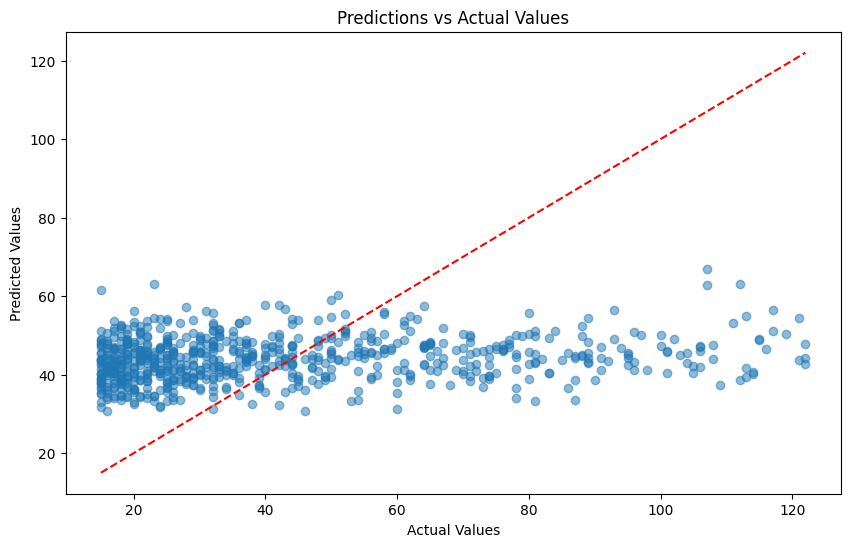

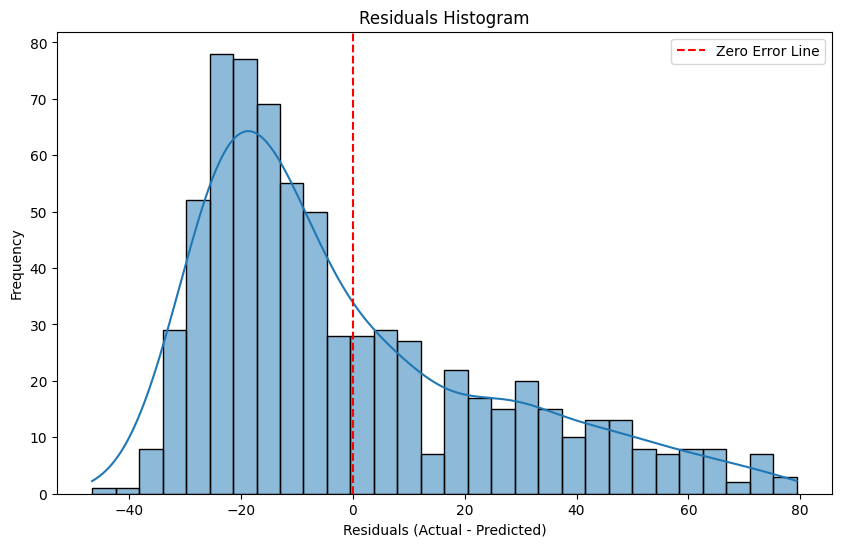

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()

### Lasso Regression

In [77]:
# Define the parameter grid for Lasso
params = {
    'alpha': uniform(0, 1),  # Regularization strength
    'fit_intercept': [True, False],  # Whether to calculate the intercept
}

# Initialize Lasso Regression
model = Lasso()

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   n_iter=100,
                                   scoring='neg_mean_absolute_error',
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train_scaled, y_train)

# Output the best parameters and model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
print("Best Model:", best_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'alpha': np.float64(0.6375574713552131), 'fit_intercept': True}
Best Model: Lasso(alpha=np.float64(0.6375574713552131))


In [ ]:
# Create the Lasso Regression model
lasso = Lasso(alpha=0.6375574713552131) 

# Fit the model
lasso.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept:", lasso.intercept_)
coef_df_lasso = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])
print(coef_df_lasso)

# Make predictions
y_pred = lasso.predict(X_test)

print(f"Lasso Regression Results")

# Average prediction
print('Average prediction:', np.mean(y_pred))

# Count the number of features with non-zero coefficients
num_features_selected = (lasso.coef_ != 0).sum()
print(f"Number of features selected by Lasso: {num_features_selected}")


# Evaluate the model
print(f"Mean Squared Error (Test Set): {metrics.mean_squared_error(y_test, y_pred)}")
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

Intercept: 62.58245652305291
                              Coefficient
MONTH                            0.037882
DAY_OF_MONTH                    -0.069040
DAY_OF_WEEK                      0.000000
CRS_ELAPSED_TIME                 0.036679
DISTANCE                        -0.006024
...                                   ...
Condition_Rain                  -0.000000
Condition_Rain / Windy          -0.000000
Condition_Snow                   0.000000
Condition_Wintry Mix             0.000000
Condition_Wintry Mix / Windy     0.000000

[132 rows x 1 columns]
Lasso Regression Results
Average prediction: 43.86554501133497
Number of features selected by Lasso: 14
Mean Squared Error (Test Set): 699.7234453460413
MAE: 21.75131185103158


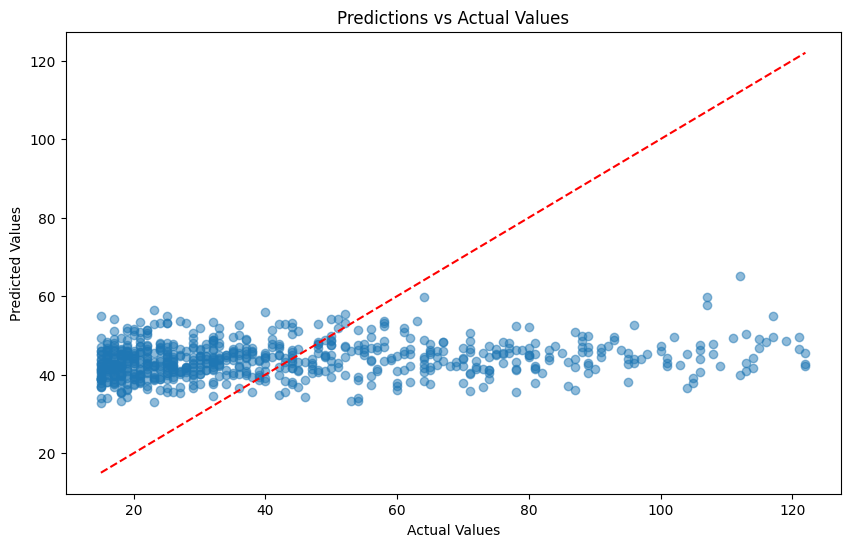

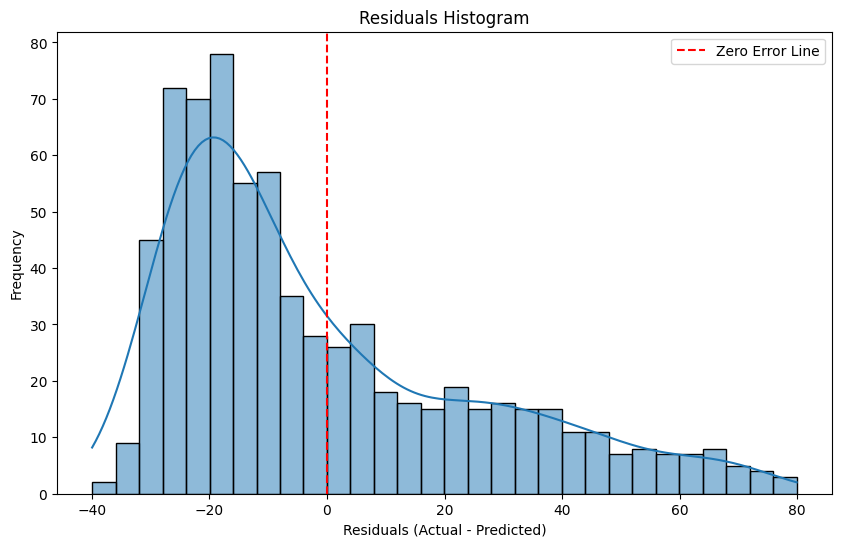

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()

### Ridge 2nd Degree Polynomial

In [ ]:
# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features (degree 2) + Ridge Regression
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('ridge', Ridge())
])

# Define hyperparameter grid
params = {
    'ridge__alpha': uniform(0, 10000),
    'ridge__fit_intercept': [True, False],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=40, 
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train_scaled, y_train)

# Output the best parameters and model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
print("Best Model:", best_model)

# Now predict on the test set using the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE Test:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE Test:", mae)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters: {'ridge__alpha': np.float64(9488.855372533333), 'ridge__fit_intercept': False}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('ridge',
                 Ridge(alpha=np.float64(9488.855372533333),
                       fit_intercept=False))])
MSE Test: 748.2978552874359
MAE Test: 21.809883130616097


### Lasso 2nd Degree Polynomial

In [76]:
# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features (degree 2) + Lasso Regression
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Degree 2 polynomial
    ('lasso', Lasso())
])

# Define hyperparameter grid
params = {
    'lasso__alpha': uniform(0, 1),
    'lasso__fit_intercept': [True, False],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=20,  # Reduce number of iterations for faster execution
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train_scaled, y_train)

# Output the best parameters and model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_
print("Best Model:", best_model)

# Now predict on the test set using the best model
y_pred = best_model.predict(X_test_scaled)

# Average prediction
print('Average prediction:', np.mean(y_pred))

# Count the number of features with non-zero coefficients
num_features_selected = (lasso.coef_ != 0).sum()
print(f"Number of features selected by Lasso: {num_features_selected}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE Test:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE Test:", mae)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'lasso__alpha': np.float64(0.9737555188414592), 'lasso__fit_intercept': True}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=np.float64(0.9737555188414592)))])
Average prediction: 43.71983154028227
Number of features selected by Lasso: 14
MSE Test: 698.7858417656895
MAE Test: 21.583370762039184


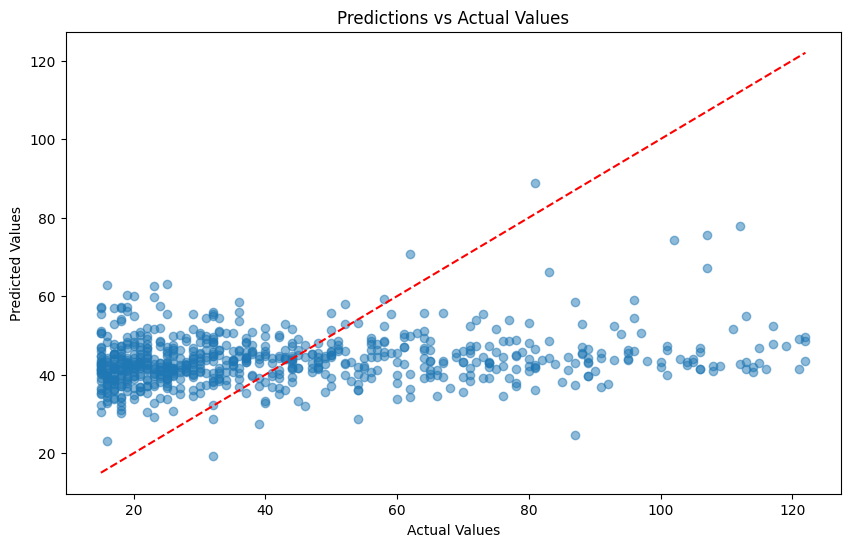

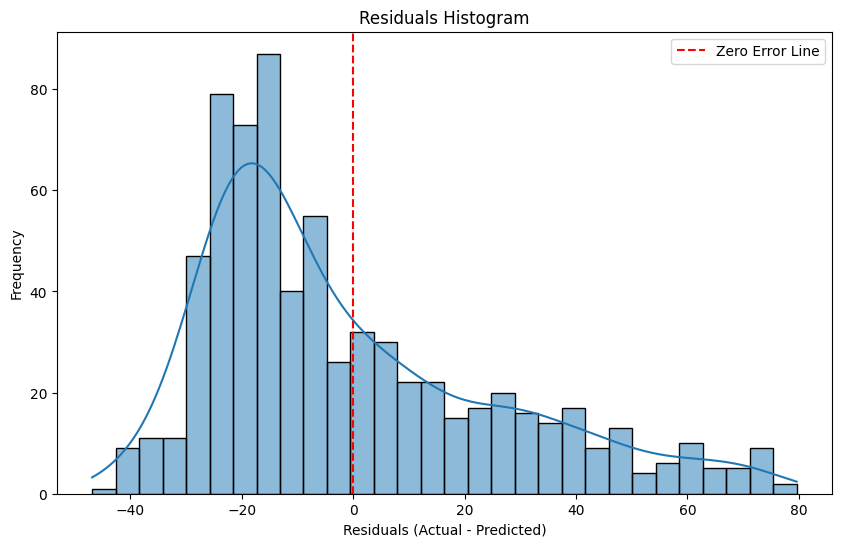

In [74]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs Actual Values")
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)  # KDE adds a smooth curve

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()

##### The optimal Linear Regression model for our dataset was discovered to be done using Ridge Regression, however 2nd degree polynomial Lasso Regression was a close second.